# Phase Transitions in Ising Spin Systems

The Ising Model is a very simple thermodynamic model, first formulated to explain ferromagnetism. One of the touchstones of modern physics, it comprises of $N$ sites of quantum spins in a $d$-dimensional lattice. The quantum spins can have either of two orientations = $\pm1$ and neighbouring spins interact. (In the absence of an external coupling field,) the energy of an Ising system is

$$ E = \Sigma_{\langle ij\rangle} H_{ij}\sigma_i\sigma_j $$

where $H_{ij}$ is the interaction energy between spins $\sigma_i$ and $\sigma_j$. Concepts of locality are well defined here as spins only interact within their own neighborhoods.

Tuning the nature of this interaction helps one realise various non-trivial physical systems and their phase transitions: if $H_{ij}>0\;(<0)\forall i,j$, the system is ferromagnetic (antiferromagnetic). 

If it can take any arbitrary sign, then it is a represents spin glasses, by virtue of encoding geometric frustration into the system.  

## Spin Glasses

These are systems with "quenched disorder", i.e. their (several) ground state configurations appear to be random (depsite not being truly random). This is very unlike (anti)ferro-magnetic systems which have simple energy landscapes with easily-found global minima. 

Spin glasses instead have lots of local minima, which also cannot be "easily escaped". This implies that if near a local minima, it requires a large shift in configuration space to find another local minima. This leads to a "metastability" in the system, where it remains stuck in seemingly random configurations for long times (thereby leading to non-ergodicity).

This leads to fascinating and complicated phenomena and understanding spin glasses has myriad applications, due to the ubiquity of complicated energy landscapes in various contexts.


We now attempt to use MCMC Methods to detect phase transitions in these Ising systems:

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Two Dimensional Ising Models


In [4]:
class TwoDim_Ising:
    def __init__(self, N = 32, model = 'ferromagnetic', boundaries = 'periodic', rng_key = None):
        """ 
        Create a 2D lattice of quantum spins, initialise a Hamiltonian based off the type of system
        and define the energy of a given configuration of spins
    
        Parameters
        ----------
        N : int
        Dimensions of the 2D spin system are (N,N)

        model : class
        The input model primarily containing a proposal function, a method to generate a new configurtion.

        boundaries : str

        rng_key : int
        The random number generator key, defaults to None.

        Methods
        -------
        energy : returns int, array
        The total energy of a configuration and an array of the energy of each individual spin

        neighbour_indices : returns array
        Helps enforce periodic boundary conditions
        
        """
        self.N = N
        self.model = model
        self.boundaries = boundaries

        if rng_key is None:
            rng_key = np.random.seed(np.random.randint(2**32))
        self.rng_key = rng_key

        self.init_condition = np.random.choice([-1,1],size=(self.N,self.N))

        # initialising the Hamiltonian, dividing into up-down and left-right neighbor interactions
        if self.model == 'ferromagnetic':    
            up = -np.ones((N,N))
            left = -np.ones((N,N))
        elif self.model == 'antiferromagnetic':
            up = np.ones((N,N)) #np.random.randn(N-1,N)#
            left = np.ones((N,N))
        elif self.model == 'spin_glass':
            up = np.random.choice([-1,1],size=(N,N)) #-1 + 2*np.random.rand(N,N) 
            left = np.random.choice([-1,1],size=(N,N)) #-1 + 2*np.random.rand(N,N)

        # boundary conditions
        if self.boundaries == 'fixed':
            down, up[0,:] = np.zeros((N,N)), np.zeros(N)
            down[:N-1,:] = up[1:,:]

            right, left[:,0] = np.zeros((N,N)), np.zeros(N)
            right[:,:N-1] = left[:,1:]

        elif self.boundaries == 'periodic':
            down = np.zeros((N,N))
            down[:N-1,:], down[N-1,:] = up[1:,:], up[0,:]

            right = np.zeros((N,N))
            right[:,:N-1], right[:,N-1] = left[:,1:], left[:,0]

        self.up = up
        self.down = down
        self.left = left
        self.right = right
        
    def neighbour_indices(self, i,j):
        return np.array([[(i-1)%self.N, j], # up_neighbour
                         [(i+1)%self.N, j], # down_neighbour
                         [i, (j-1)%self.N], # left_neighbour 
                         [i, (j+1)%self.N] ]) # right_neighbour
    # this returns periodic neighbour indices as up_neighbour, down_neighbour, left_neighbour, right_neighbour

    def energy(self, state):
        e = np.zeros((self.N, self.N))
        for i in range(self.N):
            for j in range(self.N):
                nghb = self.neighbour_indices(i, j)
                e[i,j] = state[i,j]*(self.up[i,j]*state[tuple(nghb[0])] 
                      + self.down[i,j]*state[tuple(nghb[1])] 
                      + self.left[i,j]*state[tuple(nghb[2])] 
                      + self.right[i,j]*state[tuple(nghb[3])])
        return np.sum(e)/2, e

The most simple way to generate a new spin configuration given some current state, is by flipping a single spin at random. The proposed configuration is then accepted/rejected based off energy considerations.

In [5]:
class SingleSpinFlip(TwoDim_Ising):
    """ 
    A child class to the two-dimensional Ising mode which generates a new spin
    configuration through a single flip 
    """
    def __init__(self,N = 50, model = 'ferromagnetic', boundaries = 'periodic', rng_key = None):
        super().__init__(N, model, boundaries, rng_key)

    def proposal(self, state): # a single spin flip
        i, j = np.random.choice(self.N, 2)
        new_state = np.copy(state)
        new_state[i,j] = -1*new_state[i,j]

        nghb = self.neighbour_indices(i, j)
        del_e = 2*new_state[i,j]*(self.up[i,j]*state[tuple(nghb[0])] 
                      + self.down[i,j]*state[tuple(nghb[1])] 
                      + self.left[i,j]*state[tuple(nghb[2])] 
                      + self.right[i,j]*state[tuple(nghb[3])])
        
        return new_state, del_e

## StatMech Metropolis Hastings Sampler

In [31]:
class StatMech_MHSampler:
    """
    Metropolis-Hastings sampler for generating configurations for a given statistical system.
    (written separately while the primary MH_Sampler was generalised to sample from
    any kind of target distribution)

    Parameters
    ----------
    model : object
        The system that defines configuration space, its energy and a proposal method.

    init_position : array
        The initial position in the state space.

    beta : float
        A measure of inverse temperature.

    n_steps : int
        The number of steps the sampler takes (number of proposal configurations it generates)
        """
    
    def __init__(self, model, beta = 1, n_steps = 10000):
        self.model = model # has to have energy method and init_condition_variable
        self.init_condition = model.init_condition
        self.beta = beta
        
        self.n_steps = n_steps
        self.states = [self.init_condition]
        self.energies = [self.model.energy(self.init_condition)[0]]
        self.test_energies = [self.model.energy(self.init_condition)[0]]
        self.autocorr = None
        self.magnetisation = [np.mean(self.init_condition)]

        self.acceptance_rates = 0

    def step(self, current_state, max_iter = 400):
        # accept = False
        # steps = 0
        change_e = 0

        # proposal step
        proposed_state, del_e = self.model.proposal(current_state)

        # accept or reject step
        prob_accept = np.exp(-self.beta*del_e)
        if np.random.random() < prob_accept:
            self.acceptance_rates += 1
            current_state = np.copy(proposed_state)
            change_e = del_e

        return current_state, change_e

    def run(self):
        current_state = np.copy(self.init_condition)
        init_energy = self.model.energy(self.init_condition)[0]

        for i in range(self.n_steps):
            new_state, del_e = self.step(current_state)            
            
            current_state = np.copy(new_state)
            init_energy += del_e

            self.states.append(current_state)
            self.energies.append(init_energy)
            self.test_energies.append(self.model.energy(current_state)[0])
            self.magnetisation.append(np.mean(new_state))
        
        self.energies = np.array(self.energies)
        self.test_energies = np.array(self.test_energies)
        self.states = np.array(self.states)

        self.autocorr = self.auto_correlation()

    def auto_correlation(self):
        means = []
        vars = []
        cross_corr = []
    
        for tau in np.arange(self.n_steps):    
            h_tau = np.copy(self.energies[tau:])
            h_tau /= max(np.abs(h_tau)) #/min(self.energies[tau:])
            h_t = np.copy(self.energies[:self.n_steps-tau+1])
            h_t /= max(np.abs(h_t)) #/min(self.energies[:self.n_steps-tau+1])

            cross_corr.append(np.sum(h_tau*h_t)/(self.n_steps-tau+1))
            means.append(np.mean(h_t))
            vars.append(np.var(h_t))
                
        return ((np.array(cross_corr)) - np.array(means)**2)/np.array(vars)

In [24]:
model = SingleSpinFlip(N=32,model='ferromagnetic')
problem = StatMech_MHSampler(model)
problem.run()

### Single Spin Flips for Anti/Ferromagnets and Spin Glasses
Running our sampler for the three different types of systems -

In [33]:
models = ['ferromagnetic', 'antiferromagnetic','spin_glass']
system = [StatMech_MHSampler(SingleSpinFlip(model=modtype)) for modtype in models]
for i in range(3):
    system[i].run()

/var/folders/tj/d36hhh5s38v8kjgg4z2s8mtw0000gn/T/ipykernel_26435/2530702672.py:86: RuntimeWarning: divide by zero encountered in divide
  return ((np.array(cross_corr)) - np.array(means)**2)/np.array(vars)


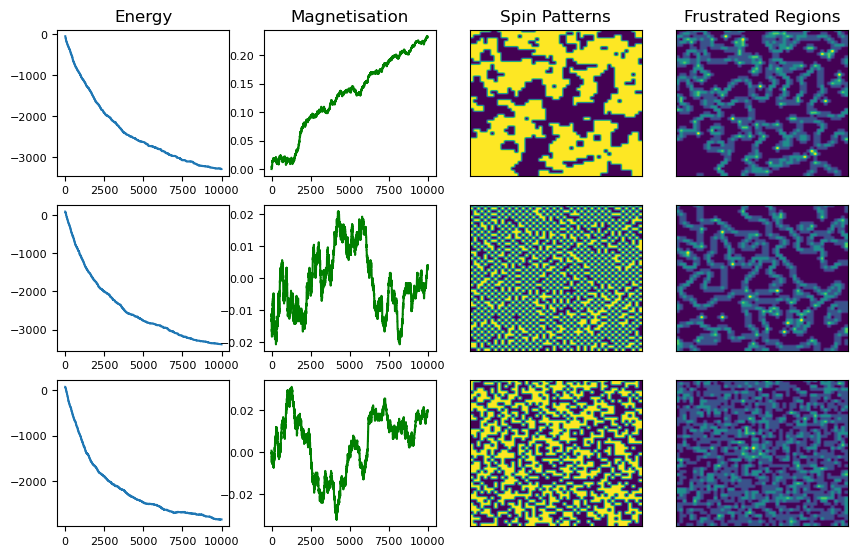

In [74]:
fig, axs = plt.subplots(nrows=3,ncols=4,figsize=(4*2.55,3*2.15))
for i in range(3):
    if i ==0:
        axs[i,0].set_title('Energy')
        axs[i,1].set_title('Magnetisation')
        axs[i,2].set_title('Spin Patterns')
        axs[i,3].set_title('Frustrated Regions')


    axs[i,0].plot(system[i].energies) #/np.max(np.abs(system[i].energies)))
    axs[i,0].tick_params(labelsize=8)
    axs[i,1].plot(system[i].magnetisation, color='green')
    axs[i,1].tick_params(labelsize=8)
    
    axs[i,2].imshow(system[i].states[-1],aspect="auto")
    axs[i,2].set_xticks([])
    axs[i,2].set_yticks([])
    
    axs[i,3].imshow(system[i].model.energy(system[i].states[-1])[1],aspect="auto")
    axs[i,3].set_xticks([])
    axs[i,3].set_yticks([])
    

We see here that the sampler finds minima in energy (even for the spin glass case)! However, while the sampler found global minima for the ferromagnetic and antiferromagnetic systems, for the spin glass case, it merely settled into a narby local minima. This is evidenced by the amount of frustration one can see in the spin glass system. 

### Order Parameters for Phase Transitions
For a system of $N$ spins, the following order parameters are well established -
1. For ferromagnetic material, the average magnetisation $m$ defined as
$$ m = \frac{1}{N}\Sigma_i\sigma_i$$
2. For spin glasses, the Edwards Anderson order parameter $q$, (each individual spin is first averaged over time)
$$ q = \frac{1}{N}\Sigma_i \left(\langle \sigma_i \rangle _t\right)^2 $$

These can help us explore what kinds of energy minima are encountered by the sampler and assess the overall sampler performance.


In [77]:
# phase transitions over temperature:
betavals = [0.001,0.01,0.1,1,10,100]

# run ferromagnetic and spin glass over a range of betas, 10 trials for each beta.

ferro_trials = [StatMech_MHSampler(SingleSpinFlip(model='ferromagnetic'), beta = beta) for beta in betavals]
spin_trials = [StatMech_MHSampler(SingleSpinFlip(model='spin_glass'), beta = beta) for beta in betavals]

for k, beta in enumerate(betavals):
    ferro_trials[k].run()
    spin_trials[k].run()

/var/folders/tj/d36hhh5s38v8kjgg4z2s8mtw0000gn/T/ipykernel_26435/2530702672.py:86: RuntimeWarning: divide by zero encountered in divide
  return ((np.array(cross_corr)) - np.array(means)**2)/np.array(vars)
/var/folders/tj/d36hhh5s38v8kjgg4z2s8mtw0000gn/T/ipykernel_26435/2530702672.py:86: RuntimeWarning: invalid value encountered in divide
  return ((np.array(cross_corr)) - np.array(means)**2)/np.array(vars)
/var/folders/tj/d36hhh5s38v8kjgg4z2s8mtw0000gn/T/ipykernel_26435/2530702672.py:25: RuntimeWarning: overflow encountered in exp
  prob_accept = np.exp(-self.beta*del_e)


In [122]:
def np_corr(energies):
    result = np.correlate(np.array(energies), np.array(energies), mode='full')
    return result[:result.size//2]/(result.size//2)
        

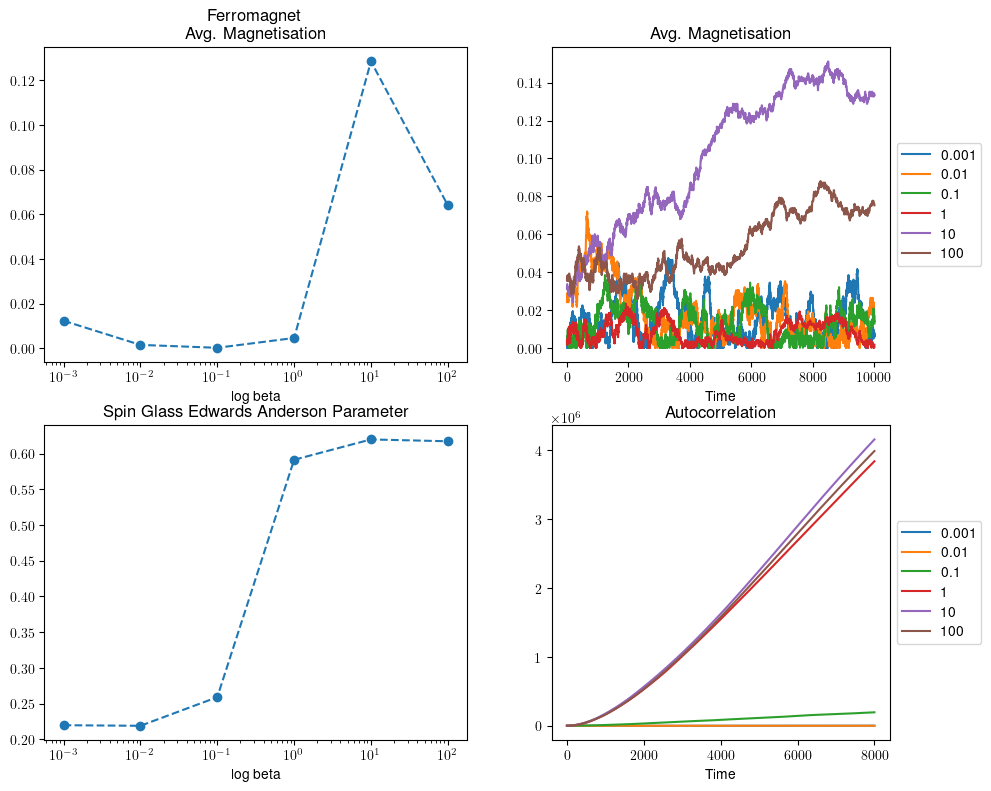

In [123]:
# Average magnetisation: order parameter for ferromagnetic substance
mags = [np.mean(ferro_trials[i].magnetisation[4000:]) for i in range(len(betavals))]

# Edwards Anderson order parameter for spin glass materials
ea = [np.mean((np.sum(spin_trials[i].states, axis=0)/spin_trials[i].n_steps)**2) for i in range(len(betavals))]

npautocorr = [np_corr(spin_trials[i].energies) for i in range(len(betavals))]

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

fig, axs = plt.subplots(nrows=2,ncols = 2, figsize = (12,9))
axs[0,0].set_xlabel('log beta')
axs[1,0].set_xlabel('log beta')
axs[0,1].set_xlabel('Time')
axs[1,1].set_xlabel('Time')

axs[0,0].set_title('Ferromagnet\nAvg. Magnetisation')
axs[1,0].set_title('\nSpin Glass Edwards Anderson Parameter')
axs[0,1].set_title('Avg. Magnetisation')
axs[1,1].set_title('Autocorrelation')


axs[0,0].semilogx(betavals, np.abs(mags), '--o')
axs[1,0].semilogx(betavals, np.abs(ea), '--o')

for k, beta in enumerate(betavals):
    axs[0,1].plot(np.abs(ferro_trials[k].magnetisation), label = beta)
    axs[1,1].plot(npautocorr[k][:8000], label = beta)

# Shrink current axis by 20%
box = axs[0,1].get_position()
axs[0,1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
axs[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

box = axs[1,1].get_position()
axs[1,1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
axs[1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Thus our order parameters show that there is indeed a phase transition occurring $\sim\beta=1$. The magnetisation time evolution in the ferromagnets too reflected this, however our autocorrelation plots in spin glasses are less than satisfying.

Due to increasing "metastability" in glassy states, one expects a slower drop off in the correlation with increasing $\beta$. While the overall trends are still promising, with correlation being higher for large $\beta$, they are increasing functions over time.

This seems to be because the variance over time decreases to almost zero because the system finds a local minima and does not budge from there. The next local minima is further than a single flip away, thus there is no scope for escape. As a result, we simply reject every proposal and remain stuck at the minima, leading to zero variance and a divergence in the autocorrelation functions. 

Thus, the natural next step is to try methods where a proposed new state differs by more than a single flip - we instead "flip by the cluster".
## Swendsen Wang Algorithm

In [124]:
from scipy.sparse.csgraph import connected_components

In [146]:
# Swendsen Wang Algorithm

class SwendsenWang(TwoDim_Ising):
    """ 
    A cluster flip algorithm which first probabilistically creates bonds between alike spins
    and then flips the spins of clusters as a whole.
    """
    def __init__(self, N = 50, model = 'ferromagnetic', boundaries = 'periodic', rng_key = None, beta = 1):
        super().__init__(N, model, boundaries, rng_key)
        self.clusters = []
        self.beta = beta

    def ij_n(self,ij):
        return self.N*ij[0] + ij[1] 
    
    def n_ij(self,n):
        return n//self.N, n%self.N
    
    def if_bond(self, n, nghb_n, Jij, state):
        nij, nghbij = self.n_ij(n), self.n_ij(nghb_n)

        if state[nij] == state[nghbij]:
            return int(np.random.random()<(np.exp(-2*self.beta*Jij)))
        else:
            return 0

    def swbonds(self, state): # bonds are determined according to the SW Algorithm
        bonds = 2*np.ones((self.N**2,self.N**2))
        for i in range(self.N):
            for j in range(self.N):
                n = self.ij_n((i,j))
                nghb_n = [self.ij_n(tuple(inds)) for inds in self.neighbour_indices(i,j)] 
                #neighbors are up, down left, right
                J_n = [self.up[i,j], self.down[i,j], self.left[i,j], self.right[i,j]]

                for k, nghb_ind in enumerate(nghb_n):
                    if bonds[n,nghb_ind] == 2:
                        bonds[n,nghb_ind] = self.if_bond(n,nghb_ind,J_n[k],state)
                        bonds[nghb_ind, n] = bonds[n,nghb_ind]
        return bonds%2
                
    def clustering(self, labels): # simply for visualistaion purposes
        cluster_vis = -10*np.ones((self.N, self.N))
        for n in range(labels.size):
            if np.argwhere(labels ==labels[n]).size > 5:
                cluster_vis[tuple(self.n_ij(n))] = labels[n]
        return cluster_vis

    def proposal(self, state): #cluster_flip
        bonds = self.swbonds(state) # N^2 * N^2
        n_components, labels = connected_components(csgraph=bonds, directed=False, return_labels=True)
    
        cluster = np.zeros((self.N, self.N))
        self.clusters.append(self.clustering(labels))

        new_state = np.copy(state)
        # labels is a 1*N^2 long vector
        # append ij_n of labels to visualise clusters

        for label in labels:
            cluster_inds = np.argwhere(labels==label)
            pflip = np.random.rand() < 0.5

            for ind in cluster_inds:
                ind_ij = self.n_ij(ind)
                cluster[tuple(ind_ij)] = label
                if pflip:
                    new_state[tuple(ind_ij)] = -1*new_state[tuple(ind_ij)] 

        return new_state, -2

### How do clusters look for different $\beta$?

In [147]:
cluster_trials = [SwendsenWang(model='spin_glass', beta = beta) for beta in betavals]

Text(0.5, 1.0, 'Proposed Spin Config')

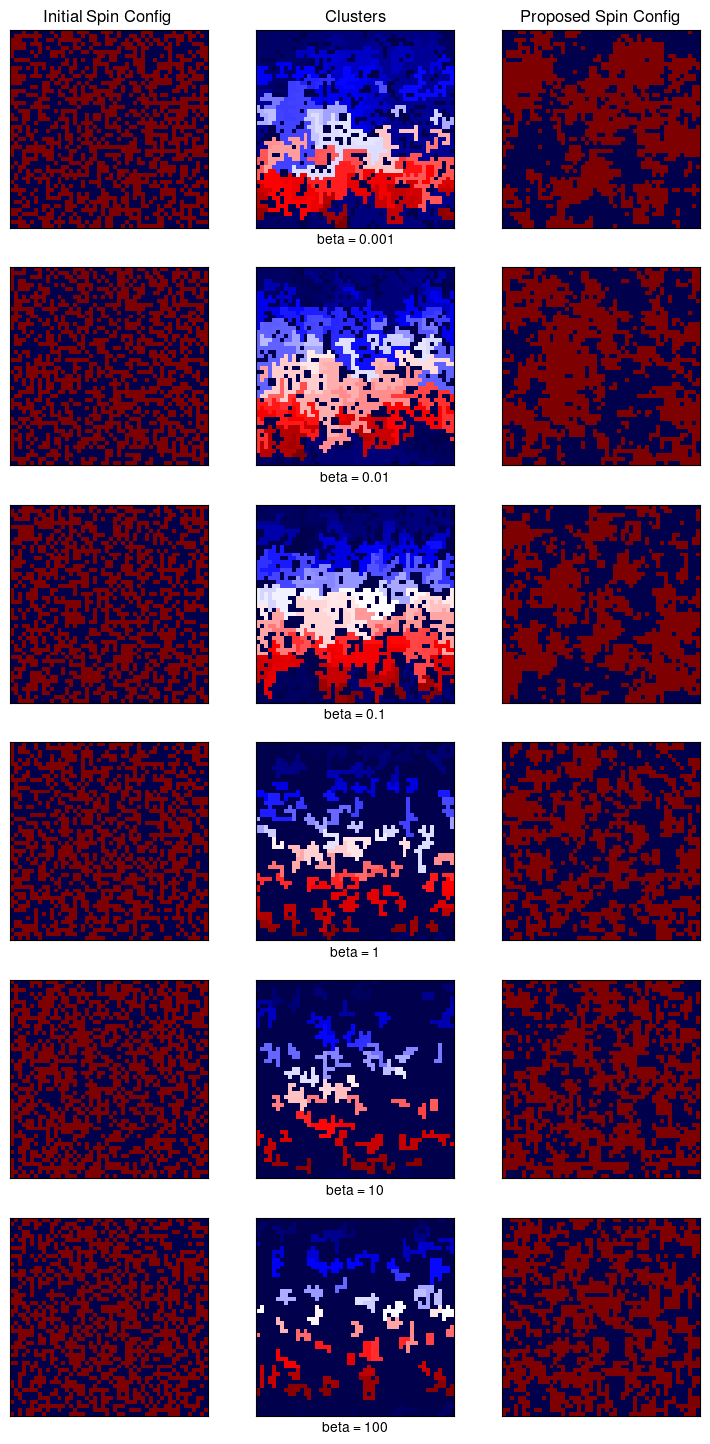

In [149]:
fig, axs = plt.subplots(nrows = 6, ncols=3, figsize = (9, 18))

for k, beta in enumerate(betavals):
    axs[k,0].imshow(cluster_trials[k].init_condition, cmap = 'seismic') #cmap='binary')
    new_state = cluster_trials[k].proposal(cluster_trials[k].init_condition)[0]
    
    axs[k,1].imshow(cluster_trials[k].clusters[0], cmap ='seismic') #cmap='tab20b')
    axs[k,2].imshow(new_state, cmap = 'seismic') #cmap='PiYG')

    axs[k,0].set_xticks([]) ; axs[k,0].set_yticks([])
    axs[k,1].set_xticks([]) ; axs[k,1].set_yticks([])
    axs[k,2].set_xticks([]) ; axs[k,2].set_yticks([])
    
    
    axs[k,1].set_xlabel(f'beta = {beta}') 

axs[0,0].set_title('Initial Spin Config')
axs[0,1].set_title('Clusters')
axs[0,2].set_title('Proposed Spin Config')


Now to run sampler and compare how our order parameters look:

In [155]:
betavals = [0.1,1,10]

cluster_spins = [StatMech_MHSampler(SwendsenWang(model='spin_glass'),beta = beta, n_steps=100) for beta in betavals]
for i in range(3):
    cluster_spins[i].run()

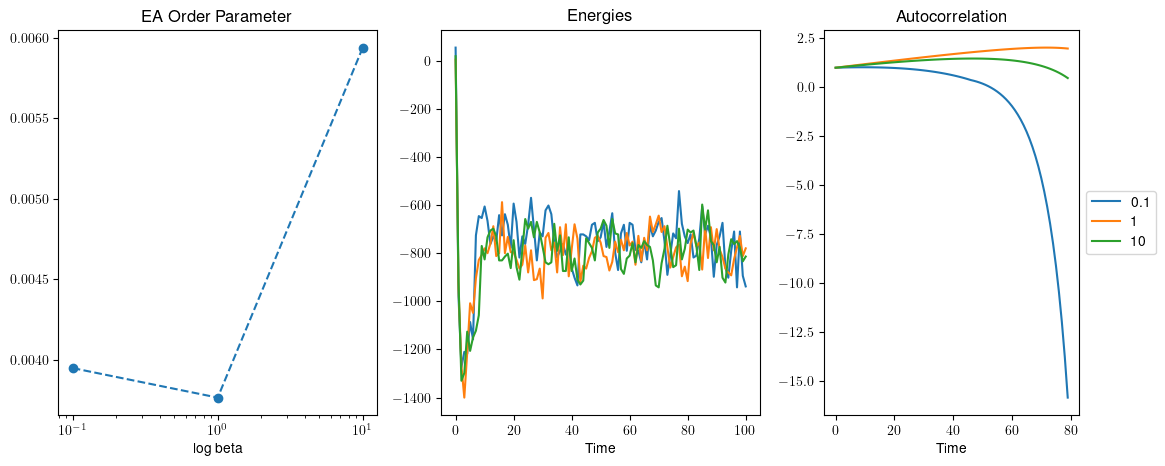

In [161]:
fig, axs = plt.subplots(nrows=1, ncols = 3, figsize = (14,5))

for i in range(3):
    axs[1].plot(cluster_spins[i].test_energies, label = f'{betavals[i]}')
    axs[2].plot(cluster_spins[i].autocorr[:80], label = f'{betavals[i]}')
    

# Edwards Anderson order parameter for spin glass materials
ea = [np.mean((np.sum(cluster_spins[i].states, axis=0)/cluster_spins[i].n_steps)**2) for i in range(3)]
axs[0].semilogx(betavals, ea,'--o')

axs[0].set_title('EA Order Parameter')
axs[1].set_title('Energies')
axs[2].set_title('Autocorrelation')

axs[0].set_xlabel('log beta')
axs[1].set_xlabel('Time')
axs[2].set_xlabel('Time')

box = axs[2].get_position()
axs[2].set_position([box.x0, box.y0, box.width * 0.8, box.height])
axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

Thus, we find that our energy landscapes for spin glass systems look much more physically accurate. The complicated, difficult-to-escape local minima can be clearly seen. 

Moreover, our autocorrelation functions look significantly more plausible. (with negative values arising primarily due to edge effects, as it was a costly simulation, it was not run for beyond 100 steps). 

Thus, cluster methods seem to be a significant improvement in simulating spin glasses.

In conclusion, we were able to detect phase transitions in 2D Ising ferromagnetic and spin glass systems using the samples generated by a Metropolis Hastings Sampler.